<a href="https://colab.research.google.com/github/Tstrebe2/colab-notebooks/blob/main/pca-from-scratch-demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data and Dependencies

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt

bc_dict = load_breast_cancer(as_frame=True)
X = bc_dict['data']
y = bc_dict['target']

Lets visualize the relationships in our data and find two related variables for our PCA demonstration.

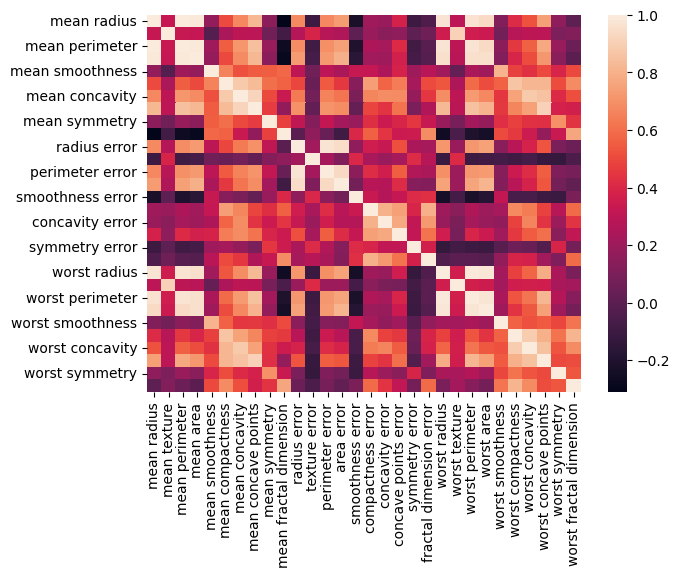

In [ ]:
plt.figure(dpi=100, figsize=(7, 5))
sns.heatmap(X.corr())
plt.show()

I'm going to choose mean radius and worst radius to demonstrate how PCA works.

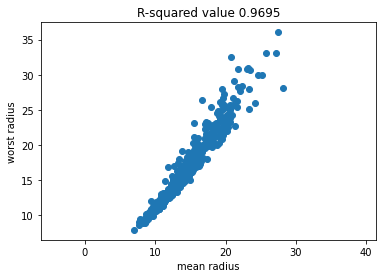

In [ ]:
features = ['mean radius', 'worst radius']
r2 = X.corr().loc[features[0], features[1]]
plt.title('R-squared value {:.4}'.format(r2))
plt.scatter(X[features[0]], X[features[1]])
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.axis('equal')
plt.show()

# PCA from Scratch

When a matrix is mean-centered on and of unit variance, the dot product of the matrix and it's transpose are equal to the covariance matrix. If we min-max scale this matrix, we will get a pearson's correlation matrix.

In [ ]:
# Lets mean-center our variables so that the principal component space
# is also mean-centered
A = X[features].values - X[features].values.mean(axis=0)
# We're going to scale our solution so that we can easily compute
# the covariance matrix
Z = A / A.std(axis=0)
cov = (Z.T @ Z)
# We will min-max scale the covariance metrix to get the
# ratio of covariance between each variable which is essentially a correlation matrix.
cov /= cov.max()

cov

array([[1.        , 0.96953897],
       [0.96953897, 1.        ]])

For proof we'll compare the outputs to the numpy.cov function.

In [ ]:
np.cov(Z.T, bias=True)

array([[1.        , 0.96953897],
       [0.96953897, 1.        ]])

For PCA, we'll compute the eigenvalues which we can use to compute the percentage of explained variance and eigenvectors of our correlation matrix (which are now the principal components) so that we can use them to generate principal scores.

In [ ]:
eig_values, eig_vectors = np.linalg.eig(cov)
# Now lets get the order (largest to smallest) of the eigenvectors so we have an ordering of our principal components
sort_ix = np.argsort(-eig_values)
# We'll order our principal components according to our eigenvalues
p_components = eig_vectors.T[sort_ix]
# The principal scores are obtained by computing the dot product of the transposed input matrix
# and the respective principal component.
p_scores_1 = p_components[0] @ Z.T
p_scores_2 = p_components[1] @ Z.T
all_pscores = np.hstack((p_scores_1.reshape(-1, 1), p_scores_2.reshape(-1, 1)))

print('explained variance of the two PCs: {}'.format(eig_values))
print('explained variance ratio of the first two components: {}'.format(eig_values/eig_values.sum()))
print('first prinicpal component values: {}'.format(p_components[0, :5]))
print('first five principal scores from the first principal component: {}'.format(all_pscores[:5, 0]))

explained variance of the two PCs: [1.96953897 0.03046103]
explained variance ratio of the first two components: [0.98476949 0.01523051]
first prinicpal component values [0.70710678 0.70710678]
first five principal scores of the first principal component [ 2.10983241  2.5708621   2.1862033  -0.7427264   2.15587798]


We can verify our results by comparing them to the SKLearn implementation

In [ ]:
pca = make_pipeline(StandardScaler(), PCA(n_components=2)).fit(X[features].values)

print('explained variance of the two PCs: {}'.format(pca[1].explained_variance_))
print('explained variance ratio of the first two components: {}'.format(pca[1].explained_variance_ratio_))
print('first prinicpal component values: {}'.format(pca[1].components_[0]))
print('first five principal scores from the first principal component: {}'.format(pca.transform(X[features].values)[:5, 0]))

explained variance of the two PCs: [1.97300647 0.03051466]
explained variance ratio of the first two components: [0.98476949 0.01523051]
first five values of the first prinicpal component [0.70710678 0.70710678]
first five principal scores of the first principal component [ 2.10983241  2.5708621   2.1862033  -0.7427264   2.15587798]


Going back to our original two features, we can create a PCA biplot to get a better sense of how Principal Component Analysis reduces the dimensionality while also preserving the global variance of our data. The first principal (PC 1) will always point to the direction of greatest variance in our data. The next PC (PC 2) will be orthogonal to PC 1 and will point in the direction of next-greatest variance. If you were to continue to add variables and components this process would repeat 3, 4, ... $N$ times.

Keep in mind that this is a 2-d dataset. While this could be done in 3 dimensions, it is impossible to visualize/conceptulalize this in 4 or more dimensions.

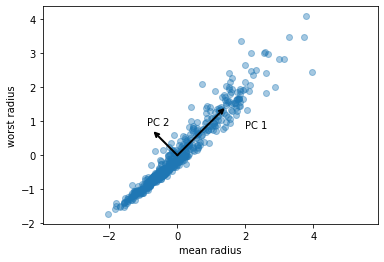

In [ ]:
pc1 = p_components[0]
pc2 = p_components[1]
# We need to mean-center the data so that we can
# accurately portray the origin of PCA (which is 0)
# Since we scaled our original data to unit variance, we will also do the
# same here so that our plot can maintain proportionality.
x = (X[features[0]] - X[features[0]].mean()) / X[features[0]].std()
y = (X[features[1]] - X[features[1]].mean()) / X[features[1]].std()

arrowprops=dict(arrowstyle='->',
                linewidth=2,
                shrinkA=0, 
                shrinkB=0)

plt.scatter(x, y, alpha=.4)

plt.annotate('', xy=pc1 * eig_values[0], xytext=np.zeros(2), arrowprops=arrowprops)
plt.annotate('PC 1', xy=pc1 * eig_values[0], xytext=(2, .8))
plt.annotate('', xy=pc2, xytext=np.zeros(2), arrowprops=arrowprops)
plt.annotate('PC 2', xy=pc2, xytext=pc2*1.25)

plt.xlabel(features[0])
plt.ylabel(features[1])

plt.axis('equal')

plt.show()